# Structural Credit Risk Models

This notebook explains the basics of the Merton and Black and Cox structural credit risk models.

In [1]:
from __future__ import division
from ipywidgets import FloatSlider, IntSlider, FloatText, interactive
from IPython.display import display
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

All based on asset evolution following geometric brownian motion:

In [2]:
def asset_evolution(initial_asset_value, asset_volatility,
                    liability_value, maturity, risk_free_rate,
                    max_time, number_of_runs, resolution):
    # Simulates geometric brownian motion asset evolution with the given parameters
    # and returns a numpy matrix of realisations.
    # Simulates up to max_time (useful for visualisation)
    # The resolution parameter sets the number of time steps per unit of time.
    
    # Convert maturity time into array indices and create the array
    maturity_index = int(maturity * resolution)
    max_time_index = int(max_time * resolution)
    asset_value_matrix = np.zeros((max_time_index, number_of_runs))
    
    # Initialise the matrix and rescale the volatility parameter
    asset_value_matrix[0,:] = initial_asset_value
    asset_volatility_adjusted = asset_volatility / math.sqrt(resolution)
    
    # Evolve the asset value
    for i in range(1, max_time_index):
        asset_return = np.random.normal(risk_free_rate / resolution, asset_volatility_adjusted, (1, number_of_runs))
        asset_value_matrix[i, :] = asset_value_matrix[i-1, :] * (1+asset_return)

    return asset_value_matrix

## Merton

Asset evolves.  If at maturity its less than the face value of debt, firm defaults.  Closed form solution can be given.


In [3]:
def merton_pd_cf(initial_asset_value, asset_volatility,
                 liability_value, maturity, risk_free_rate):
    # Closed form solution for the Merton model

    def d_minus(a, s, l, t, r):
        return (math.log(a / l) + (r - 0.5 * (s ** 2)) * t) / (s * math.sqrt(t))
    
    return norm.cdf(-d_minus(initial_asset_value, asset_volatility, liability_value, maturity, risk_free_rate))


Here's an interactive version:

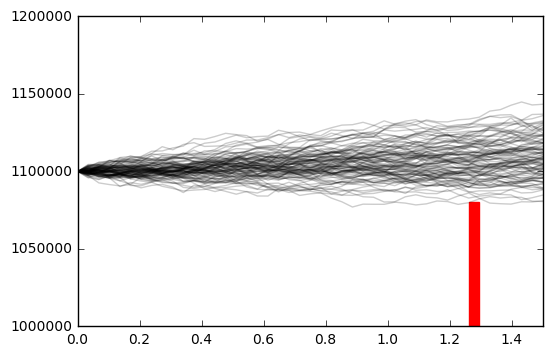

In [5]:
def m(a, s, l, t, r, runs, resolution):
    
    # We want to simulate to 20% beyond the maturity time
    max_time = t * 1.2
    
    # Create vector for the x-axis
    x = np.linspace(0, max_time, int(resolution*max_time))
    
    # Do the simulation
    asset_value_matrix  = asset_evolution(a, s, l, t, r, max_time, runs, resolution)
    
    # Create a vector for the liability
    liability_bar = np.zeros( (int(resolution*max_time), 1) )
    liability_bar[ int(resolution*t)] = l

    # Plot the 'barrier' in red and the asset value realisations in slightly transparent black.
    plt.bar(x, liability_bar, width=(1/resolution), facecolor='r', edgecolor='r', alpha=1)
    plt.plot(x, asset_value_matrix, 'k', alpha=0.2, linewidth=1)
    plt.axis([0, max_time, 1e6, 0.12e7])
    
    # Calculate the proportion of occurances where the asset value is below liability value at time t
    tf = asset_value_matrix[int(resolution*t), :] < l
    pd = sum(tf) / len(tf)
    
    global estimatedMertonPD
    global actualMertonPD
    estimatedMertonPD.value = round(pd, 4)
    actualMertonPD.value    = round(merton_pd_cf(a, s, l, t, r), 4)


asset_value     = IntSlider(min=1e6, max=1.2e6, step=1e4, value=1.1e6, description="Asset value")
asset_vol       = FloatSlider(min=0.001, max=0.1, step=0.001, value=0.00893, description="Asset vol")
liability_value = IntSlider(min=1e6, max=1.2e6, step=1e3, value=1.08e6, description="Liabilities")
maturity        = FloatSlider(min=0.1, max=10, step=0.1, value=1.25, description="Maturity")
risk_free_rate  = FloatSlider(min=0, max=0.07, step=0.0001, value=0.0045, description="Risk free rate")
number_of_runs  = IntSlider(min=1, max=1000, step=1, value=100, description="Number of runs")
resolution      = IntSlider(min=1, max=100, step=1, value=30, description="Resolution")

estimatedMertonPD = FloatText(description="Estimated PD:")
actualMertonPD    = FloatText(description="Actual PD:")

x = interactive(m,
                a=asset_value,
                s=asset_vol,
                l=liability_value,
                t=maturity,
                r=risk_free_rate,
                runs=number_of_runs,
                resolution=resolution)

display(x)
display(estimatedMertonPD, actualMertonPD)

## Black and Cox

First passage model.  Like Merton but different.  Firm defaults if asset value falls below face value of liabilities at any point.  Again, we can have a closed form solution, slightly more complex.

In [6]:
def blackcox_pd_cf(initial_asset_value, asset_volatility, liability_value, maturity, risk_free_rate):
    # Closed form solution for the Black and Cox first passage model

    def fp(d, m, t):
        if d < 0:
            d = 0
        
        return (norm.cdf((d - m * t) / math.sqrt(t)) -
            (math.exp(2 * m * d) * norm.cdf((-d - m * t) / math.sqrt(t))) )

    # k is the rate for discounting the barrier. We set to zero for a fixed face value over time
    k = 0
    m = (1 / asset_volatility) * (risk_free_rate - ((asset_volatility ** 2) / 2) - k)
    d = (1 / asset_volatility) * math.log(liability_value / initial_asset_value)
    return 1 - fp(-d, -m, maturity)

And an interactive version:

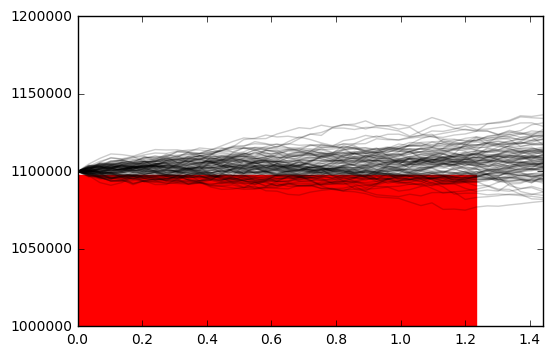

In [7]:
def bc(a, s, l, t, r, runs, resolution):
    
    # We want to simulate to 20% beyond the maturity time
    max_time = t * 1.2
    
    # Create vector for the x-axis
    x = np.linspace(0, max_time, int(resolution*max_time))
    
    # Do the simulation
    asset_value_matrix  = asset_evolution(a, s, l, t, r, max_time, runs, resolution)
    
    # Create a vector for the liability
    vec1 = np.ones(  int(resolution*t) ) * l
    vec2 = np.zeros( int(resolution*max_time)-int(resolution*t))
    liability_bar = np.concatenate( (vec1, vec2) )
    
    # Plot the 'barrier' in red and the asset value realisations in slightly transparent black.
    plt.bar(x, liability_bar, width=(1/resolution), facecolor='r', edgecolor='r', alpha=1)
    plt.plot(x, asset_value_matrix, 'k', alpha=0.2, linewidth=1)
    plt.axis([0, max_time, 1e6, 0.12e7])
    
    # Calculate the proportion of occurances where the asset value is ever below liability value
    tf = asset_value_matrix[:, :] - l
    # For each row, check to see if it ever went negative
    count = 0
    for i in range(1, runs):
        if sum(tf[:,i] < 0) > 0:
            count = count + 1
    
    pd = count / runs
    
    global estimatedBCPD
    global actualBCPD
    estimatedBCPD.value = round(pd, 4)
    actualBCPD.value    = round(blackcox_pd_cf(a, s, l, t, r), 4)


asset_value     = IntSlider(min=1e6, max=1.2e6, step=1e4, value=1.1e6, description="Asset value")
asset_vol       = FloatSlider(min=0.001, max=0.1, step=0.001, value=0.00893, description="Asset vol")
liability_value = IntSlider(min=1e6, max=1.2e6, step=1e3, value=1.08e6, description="Liabilities")
maturity        = FloatSlider(min=0.1, max=10, step=0.1, value=1.25, description="Maturity")
risk_free_rate  = FloatSlider(min=0, max=0.07, step=0.0001, value=0.0045, description="Risk free rate")
number_of_runs  = IntSlider(min=1, max=1000, step=1, value=100, description="Number of runs")
resolution      = IntSlider(min=1, max=100, step=1, value=30, description="Resolution")

estimatedBCPD = FloatText(description="Estimated PD:")
actualBCPD    = FloatText(description="Actual PD:")

x = interactive(bc,
                a=asset_value,
                s=asset_vol,
                l=liability_value,
                t=maturity,
                r=risk_free_rate,
                runs=number_of_runs,
                resolution=resolution)

display(x)
display(estimatedBCPD, actualBCPD)